In [ ]:
# importing required libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import lightgbm as lgb
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [ ]:
# link to the dataset
# https://herts365-my.sharepoint.com/:x:/r/personal/sm22acy_herts_ac_uk/Documents/MSc_Project_21078559/CA_1_Validation.csv?d=w65fa962c6c184edcb58c8bfa63094b7a&csf=1&web=1&e=fec2SF

In [2]:
sales_data = pd.read_csv('CA_1_Validation.csv')

sales_data.head(5)

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  
1       1       0       0       0       0  
2       1       0       1       1       1  
3       0       1       3       7       2  
4       1       2       2       2       4  

[5 rows x 1919 columns]

In [ ]:
# reducing memory of features

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if col_type =='category': 
            df[col] = df[col].astype('category').cat.as_ordered()
            #faced an error where you cannot calculate the max and min value that an category can take
        
        elif col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


sales_data = reduce_mem_usage(sales_data)

Memory usage of dataframe is 44.64 MB
Memory usage after optimization is: 6.50 MB
Decreased by 85.4%


data = pd.melt(sales_data, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sales')

In [20]:
# data preprocessing

In [4]:
def reshape_data(data):
    id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
    value_vars = [col for col in sales_data.columns if col.startswith('d_')]
    
    # Melt the DataFrame
    data_long = pd.melt(sales_data, id_vars=id_vars, value_vars=value_vars, 
                    var_name='day', value_name='sales')
    data_long['day'] = data_long['day'].str.replace('d_', '').astype(int)

    data_long['date'] = pd.to_datetime('2011-01-29') + pd.to_timedelta(data_long['day'] - 1, unit='D')
    return data_long

data_long = reshape_data(sales_data)

In [5]:
data_long.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  day  sales       date  
0       CA    1      0 2011-01-29  
1       CA    1      0 2011-01-29  
2       CA    1      0 2011-01-29  
3       CA    1      0 2011-01-29  
4       CA    1      0 2011-01-29

In [6]:
data_long.columns = data_long.columns.str.strip()

In [7]:
#data_encoded = pd.get_dummies(data, columns=['event_name_1','event_type_1','event_name_2','event_type_2'])

In [8]:
#data = data.drop(['d','wday','month'], axis=1)

In [ ]:
# forecast_sku function creates predictions for each unique product. Whats unique in this iteration is the
# incorporation of date-time features i.e month, dayofweek and year and rolling window statistics
# such as rolling mean and rolling standard deviation

In [9]:
def forecast_sku(data, sku_id, lags, horizon):
    sku_data = data[data['id'] == sku_id].copy()
    # sku_data = prepare_lag_features(sku_data, lags)
    sku_data['date'] = pd.to_datetime(sku_data['date'])
    sku_data.set_index('date', inplace=True)
    sku_data.index.freq = 'D'

    # create date-time features
    sku_data["month"] = sku_data.index.month
    sku_data["day1"] = sku_data.index.dayofweek
    sku_data["year"] = sku_data.index.year

    # rolling windows 7
    result = (
    sku_data["sales"]
    .rolling(window=7) # Pick window size.
    .agg(["mean", "std"]) # Pick statistics.
    .shift(periods =1) # Lag by 1 hour to avoid data leakage.
    )  
    result = result.add_prefix("y_window_7_")
    sku_data = sku_data.merge(result, how="left", left_index=True, right_index=True)

        # rolling window 14
    result = (
    sku_data["sales"]
    .rolling(window=14) # Pick window size.
    .agg(["mean", "std"]) # Pick statistics.
    .shift(periods=1) # Lag by 1 hour to avoid data leakage.
    )  
    result = result.add_prefix("y_window_14_")
    sku_data = sku_data.merge(result, how="left", left_index=True, right_index=True)
    
    X = sku_data.drop(columns=['sales', 'id', 'day','sales','item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])
    y = sku_data['sales']
    
        # Train/test split
    X_train, X_test = X[:-horizon], X[-horizon:]
    y_train, y_test = y[:-horizon], y[-horizon:]
    
    # LightGBM model, adding external features in forecaster.fit
    forecaster = ForecasterAutoreg(regressor=lgb.LGBMRegressor(), lags=lags)
    forecaster.fit(y=y_train, exog = X_train[['month','day1','year','y_window_7_mean','y_window_7_std','y_window_14_mean','y_window_14_std']])
    
    # Forecast, we also provide external features in exog parameter to predict the next 28 days
    predictions = forecaster.predict(steps=horizon, exog = X_test[['month','day1','year','y_window_7_mean','y_window_7_std','y_window_14_mean','y_window_14_std']])
    
    # Ensure the index aligns with the original data
    #date_range = pd.date_range(start=sku_data['date'].max() + pd.Timedelta(days=1), periods=horizon, freq='D')
    return pd.Series(predictions)



In [10]:
# Define lags and horizon
lags = [1, 2, 3, 4, 5, 6, 7, 14, 21, 28]
horizon = 28  # Forecast horizon (e.g., 28 days)

# Dictionary to store SKU forecasts
sku_ids = data_long['id'].unique()
sku_predictions = {sku_id: forecast_sku(data_long, sku_id, lags, horizon) for sku_id in sku_ids}

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 304
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.308562


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.264405


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 225
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.146473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.743134


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 655
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.975229


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 703
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.875067


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 165
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.222402


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 7.256327


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.175552


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 584
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.727518


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 109
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.075929


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 188
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.393107


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.257943


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 691
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.268713


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 6.140011


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1131
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.522348


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.060851


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 101
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.047388


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.720517


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 218
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.323640


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.673129


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 228
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.332256


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 680
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.120086


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 253
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.249865


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.478729


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 7
[LightGBM] [Info] Start training from score 0.007539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.192784


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.708670


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 699
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.471190


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.922456


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.355950


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1243
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.520732


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 178
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.170705


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 391
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.485730


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.140549


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.627894


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.767905


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.389338


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 123
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.103393


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 610
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.607970


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.309639


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.521809


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.344642


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.934303


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.130856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.164782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.149165


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1323
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 7.230479


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 247
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.311793


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.921379


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.138934


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 110
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.063543


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.082929


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.103931


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 719
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.683360


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.825525


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.635433


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 383
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.444265


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 167
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.184168


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 247
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.303716


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 108
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.060312


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.177167


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 691
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.535810


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.088314


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 390
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.241788


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1205
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.134626


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.935918


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.392569


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 104
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.087776


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 449
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.594507


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 221
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.403339


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 742
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.634895


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.582122


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 581
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.589122


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 226
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.243942


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 757
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.969844


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.056004


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1111
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.517501


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 615
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.579968


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.137857


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 158
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.189015


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 612
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.846527


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.940226


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.069467


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.576198


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 508
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.445880


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.562197


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 917
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.651050


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.315563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 166
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.229941


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.190092


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.342488


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 135
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.141088


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.561659


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 280
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.438880


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.946688


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 393
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.693592


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 110
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.116855


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 992
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.046850


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.102316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.852989


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.269251


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.072698


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 614
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.063543


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 246
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.456651


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 165
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.189553


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 537
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.486807


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 133
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.103393


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 154
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.097469


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.217555


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 693
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.496500


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 293
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.277868


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 133
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.202477


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.154012


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.427571


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.322025


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 586
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.378568


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 582
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.570275


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 375
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.539580


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.719440


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 227
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.124394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.356489


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 595
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.624663


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.215401


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 449
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.625740


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 701
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.045773


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 771
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.739365


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.996769


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.303716


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 890
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.213786


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 124
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.100700


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.066236


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.584276


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.113086


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 543
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.383953


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.347334


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 686
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.980075


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.435110


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 335
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.408185


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 514
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.902531


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 700
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.638665


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 491
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.507808


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 954
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.173398


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.185245


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 536
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.773829


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 807
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.840065


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.702208


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.295100


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 709
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.255250


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 693
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.122240


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 747
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.500269


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 404
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.273560


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 341
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.696284


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.055466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.088314


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 216
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.382876


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 538
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.320948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 182
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.136241


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.337641


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.988153


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.263328


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.955304


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.558428


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.181475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1197
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.622509


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.166397


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 228
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.197092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 562
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.724825


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 365
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.473883


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 108
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.074313


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 195
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.196554


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.169090


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 718
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.085083


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1324
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 8.289176


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 619
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.015617


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 139
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.136241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 104
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.059774


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 356
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.372644


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.171244


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.315563


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 195
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.148088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 393
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.473344


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 135
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.114163


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1218
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 6.315563


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.074313


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 123
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.060312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 115
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.076467


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 365
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.430264


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.570813


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 381
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.653743


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 133
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.155089


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 526
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.684976


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.200323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 457
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.658589


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.294561


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 733
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.277329


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 248
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.265482


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.179860
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 115
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.102316


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.400646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 129
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.176090


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 683
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.830372


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 951
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.288638


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 278
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.180937


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 639
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.507270
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 105
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.065159


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.698977


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.119548


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.908993


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 731
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.105547


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 124
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.105008


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.171782


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 139
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.097469


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 398
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.385030


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.305870


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 600
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.396338


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.198169


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.404954


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 494
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.751750


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 342
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.315563


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 524
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.963382


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 162
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.114701


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 109
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.122240


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 383
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.577814


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.464728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 967
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.274098


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.877760


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.610662


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1013
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.281637


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 600
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.940765


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 278
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.456112


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 423
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.446957


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.537426


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.759289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.980614


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 153
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.148627


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1159
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.970921


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 124
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.100162


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.295100


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.389338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.926764


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.940226


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 178
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.174475


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 199
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.157781


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 501
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.428648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 340
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.277868


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1230
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 7.830910


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 647
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.467421


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1369
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 8.035541


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.170167


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 703
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.415724


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.234787


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 305
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.496500


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1165
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.204631


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 226
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.198169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 181
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.173398


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.457189


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.260097


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 509
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.588045


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 132
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.098546


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 9.792676


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 181
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.085622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.599892


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.189553


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 110
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.078083


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.245019


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 122
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.067313


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 463
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.618740


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.754981


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 690
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.849219


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1449
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 6.794830


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 276
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.187938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.883145


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 377
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.467959


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 514
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.589661


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.102316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 108
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.122240


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.067313


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 969
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.444265


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.835757


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1099
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.048465


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 221
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.272482


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.242865


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 256
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.239634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 310
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.339257


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 148
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.116317


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1252
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 6.548196


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 387
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.562197


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.965536


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.808831


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.131395


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 706
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.337641


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 517
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.809908


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.040388


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.343026


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 164
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.123317


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.198169


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 213
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.198708


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.133549


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 383
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.418955


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.682822


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.542811


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.120086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1120
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.190092


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 680
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.078621


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.119548


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 273
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.225633


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 743
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.886914


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 443
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.885837


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.149165


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1025
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.010770


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.983845


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.251481


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.135164


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.377491


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.836834


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 161
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.120625


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 497
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.486268


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 608
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.806139


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 484
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.759828


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.339257


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 595
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.986537


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.315563


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 526
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.737211


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 216
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.201939


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 335
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.367798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.220248
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.064620


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 821
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.028002


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.207862


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.590738


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.185784


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1375
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 7.307485


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.316101


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.633818


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.260635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 745
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.780829


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 312
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.269251


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.213786


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1601
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 12.085622


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 690
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.618201


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 385
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.358104


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.668282


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 483
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.374260


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 940
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.085083


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.631125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.688207


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 452
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.551966


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.862682


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 546
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.658051


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.088853


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.163705


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 183
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.284330


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 150
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.102854


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 181
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.221325


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.056543


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 132
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.126548


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.155089


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 675
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.061928


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 187
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.236941


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1036
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.547119


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1423
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 7.688207


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1449
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 11.704362


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.680668


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 395
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.606354


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.703823


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 95
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.056543


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.183091


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.197092


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 744
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.638126


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 721
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.454496


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 733
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.056004


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1041
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.743673


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 402
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.631664


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.688207


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 652
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.724286


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 189
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.103393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.359181


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1242
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.660743


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.770059


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.108239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.266559


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.134626


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 341
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.378029
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.185245


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 539
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.747442


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 248
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.198169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 164
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.113086


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 563
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.554658


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1249
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.556274


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 415
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.496500


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.780291


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.114701


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 111
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.069467


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 181
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.254173


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1187
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.704900


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 165
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.184168


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.168551


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.369413


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 890
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.512116


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 538
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.934303


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 203
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.279483


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 353
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.413032


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 416
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.463113


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 543
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.663436


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.389338


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 574
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.978460


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 537
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.067851


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1137
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.680129


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.325794


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 228
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.209478


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.780829


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 548
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.648358


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 149
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.125471


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 673
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.310716


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 733
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.995692


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 93
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.089930


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.231018


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.242326


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.153473


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.113624


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 203
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.166397


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 518
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.406570


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 109
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.117394


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 281
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.318794


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 83
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.036080


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 362
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.281637


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 136
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.066236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 93
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.078083


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.063005


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 79
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.026925


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 127
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.096392


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 204
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.159397


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 364
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.296715


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.134087


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.122240


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 109
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.046311


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 157
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.180937


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.038234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 344
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.272482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 117
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.064082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 362
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.214324


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 133
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.056543


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 588
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.417878


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.383414


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 136
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.080775


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.058158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 493
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.377491


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.758212


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 147
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.084006


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 116
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.047388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.710824


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.073775


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.098008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 161
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.127087


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 139
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.047388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 268
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.142703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 493
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.334410


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.429725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 99
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.107701


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 167
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.119548


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 180
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.143780


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 115
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.063543


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 300
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.214863


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 147
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.108239


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 140
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.090468


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 284
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.228864


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.075929


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 499
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.425956


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 151
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.108778


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.066236


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 132
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.092084


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 276
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.166936


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.133010
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.309101


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.280560


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.155089


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.125471


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 316
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.274098


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 143
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.073236


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 162
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.075929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 129
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.096931


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.078621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 225
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.185784


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.162628


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.093700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.094238


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 187
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.138395


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 106
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.082391


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.130856


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.797523


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 452
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.330102


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 124
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.070544


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.196015


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.064082


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 92
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.096931


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 133
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.068390


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 153
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.060312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.322563


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 153
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.054927


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 481
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.337103


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 92
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.055466


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 148
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.110932


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 362
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.349488


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 316
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.247173


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.059235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 423
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.280560


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 165
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.126010


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 212
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.159935


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.058158


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.090468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 246
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.255250


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.073775


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 473
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.304254


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.050081


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 350
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.314486


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.123856


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.191707


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 284
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.256327


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.106624


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 215
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.196554


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 106
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.049542


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.149165


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.052773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 164
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.094238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.124394


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.051158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.136241


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 225
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.178783


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 162
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.083468


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 371
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.426494


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 241
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.221325


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 404
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.340334


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.101239


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 75
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.031233


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 374
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.347334


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.165320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 323
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.197631


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 127
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.122779


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.625202


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 131
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.113624


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 272
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.157781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 116
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.078083


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.114163


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 818
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.069467


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.168013


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.289715


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 225
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.089391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 335
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.229941


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 108
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.077544


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.087237


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 305
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.196015


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.163705


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.046850


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.099623


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.207324


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 157
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.143242


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 849
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.331718


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 270
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.161551


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.130318


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 322
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.294023


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 147
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.119009


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.143780


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 309
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.218632


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.151319


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.346257


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.267636


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 535
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.585353


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 749
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.330641


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 719
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.207862


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 683
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.196554


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 788
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.335487


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 453
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.483576


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 235
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.199246


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 498
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.419494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.900377


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 534
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.436726


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.835757


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 402
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.508885


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.165320


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 752
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.586968


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 671
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.550889


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 314
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.252019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1061
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.420571


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 316
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.306947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.166397


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.125471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.246634


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 469
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.384491


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 394
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.670436


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.562736


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 799
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.704362


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 693
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.337641


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 604
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.637049


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 673
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.876683


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 938
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.487345


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.657512


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.684437


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 309
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.422725


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 132
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.060851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 314
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.360258


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 707
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.091007


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 730
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.258481


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 834
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.535272


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 659
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.680129


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 275
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.217555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 215
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.176090
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 771
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.160474


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 692
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.214863


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.833064


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.184168


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 312
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.199785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.366182


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.017232


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.301562


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 752
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.015617


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.098008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 731
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.103393


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 513
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.583199


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.159397


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 494
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.474960


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.214324


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.093161


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.692515


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 692
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.124394


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 316
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.247711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 243
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.198169


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 806
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.378568


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 972
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.634356


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.956920


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 687
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.506193


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 656
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.892299


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.891761


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.830372


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 729
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.622509


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.306408


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.480883


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.306947


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.256866


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 427
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.417878


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.920840


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 658
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.339795


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 150
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.182014


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.257404


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 730
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.406570


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 950
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.641896


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.164782


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 770
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.637588


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.551427


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 444
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.660205


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 493
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.677975


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 826
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.073775


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.749058


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.123317


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.866990


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 725
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.332256


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 336
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.377491


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.402262


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 414
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.568121


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.097469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 507
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.636511


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.627894


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 654
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.090468


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 377
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.439957


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 701
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.949919


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.077544


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.656974


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.419494


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.145396


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 165
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.188476


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 670
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.465805


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1134
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 6.260097


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.592892


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 675
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.588045


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 827
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.848142


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.236403


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 149
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.086699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 278
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.304254


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1056
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 7.598815


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 766
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.596123


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 313
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.437264


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 502
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.746365


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 712
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.071621


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 310
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.380722


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 710
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.730749


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 446
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.683360


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 308
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.533656


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.960689


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 663
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.321486


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.594507


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 654
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.744750


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 323
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.232095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 781
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.559505


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.667744


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 481
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.548196


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 687
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.721055


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 707
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.740442


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 147
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.059235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.925148


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.129241


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 652
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.422186


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 707
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.124933


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.739903


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 706
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.006462


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.315563


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 761
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.173936


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.210016


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 751
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.089930


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 295
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.216478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 791
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.844373


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 143
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.136241


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 927
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.686591


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.202477


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 737
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.577275


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 457
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.520732


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.701669


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 455
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.501346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.857297


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 615
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.737211


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.077006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 559
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.498115


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 195
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.231018


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.942380


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 147
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.111470
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.553043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.856220


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.661820


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 528
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.611739


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 546
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.848681


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 798
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.375875


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 499
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.564351


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 659
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.031772


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.589661


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.906839


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 389
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.283253


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 660
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.656974


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 469
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.689822


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 744
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.047927


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 384
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.542811


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 927
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.817447


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.623586


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 615
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.948304


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 522
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.613355


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.266020


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.858374


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 599
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.731826


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.598815


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.110932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.408185


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 279
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.157781


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.261712


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 958
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.136780


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.491653


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.758751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.849219


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.333872


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 825
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.486807


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 703
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.025848


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 835
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.369413


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.288638


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 378
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.431879


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 248
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.151858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 722
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.513193


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 683
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.996230


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 881
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.822833


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.595584


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.207862


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 278
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.372106


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.390415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 226
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.115778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.124933


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 499
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.542811


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 682
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.934841


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.358104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 825
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.042003


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.967690


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 132
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.077006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.928918


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 660
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.953150


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 716
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.878837


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 675
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.961766


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 241
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.253635


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 794
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.232633


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 375
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.477114


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.426494


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.064620


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.759828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 465
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.450188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.442649


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 380
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.422186


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 381
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.499731


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.379106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 501
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.688207


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 272
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.228325


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.790522


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.399031


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 773
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.995692


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.099085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 514
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.609047


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 218
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.233710


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.787291


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.084545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 751
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.958535


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 362
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.414647


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.519655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.533118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.099623


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 506
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.754443


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.855143


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.133010


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 737
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.936995


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 254
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.288638


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.164243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 957
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.487345


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.381799


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 483
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.819602


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 341
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.460959


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.062466


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.857835


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.075390


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 364
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.501885


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 866
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.700054


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 218
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.156166


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 204
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.139472


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 542
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.887991


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.270328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.271944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 514
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.547119


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 324
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.334410


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.262251


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.142703


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.110393


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.096931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 733
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.429187


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 110
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.185245


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 983
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.036618


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.592353


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.650512


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.493807


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 490
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.590199


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.500269


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 713
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.978998


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 518
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.433495


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 756
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.877760


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.091546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 578
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.141088


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 427
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.531502


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.628971


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 527
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.445880


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 744
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.382337


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.413032


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 629
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.516424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.558428


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 433
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.602046


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.246634


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.096931


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.915455


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.541734


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 107
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.030156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.978998


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.222402


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 989
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.031233


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 849
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.468498


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 610
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.495961


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 655
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.831449


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 700
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.927841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 140
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.082929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.821756


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 729
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.667744


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 489
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.358104


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.332256


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.816909


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 99
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.037695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 209
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.235864


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 713
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.155089


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.452342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 773
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.804523


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 700
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.793215


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 301
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.323640


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 761
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.752827


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.554120


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.089391


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 403
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.757135


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 703
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.974690


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 361
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.336564


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 949
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.737211


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 679
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.761443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.703823


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.448573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 529
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.572429


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 308
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.213247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 507
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.818525


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 6.693592


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.127625


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 639
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.810985


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.411955


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.412493


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1016
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.057081


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 279
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.323102


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 293
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.312332


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 334
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.480883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 713
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.121163


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 706
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.029079


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.814755


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.778675


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 711
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.455035


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 742
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.373183


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 701
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.920840


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 736
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.586968


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 979
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.690899


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.795369


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.932149


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 225
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.226710


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.476037


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 707
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.931610


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 534
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.780829


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 643
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.738826


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 256
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.417340


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 873
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.125471


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 454
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.654281


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 340
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.382337


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 680
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.150781


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 498
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.794292


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 718
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.179860


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.328487


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 230
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.344103


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 712
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.436187


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 671
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.417340


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.315024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 701
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.168013


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 926
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.143242


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 656
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.679052


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 446
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.452881


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 650
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.597200


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 322
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.591276


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 7
[LightGBM] [Info] Start training from score 0.009693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 709
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.294561


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 384
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.416263


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.292946


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.276791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.847604


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.239634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 701
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.393646


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 723
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.388261


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 799
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.642434


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.144857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 955
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.510501


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.371567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.645127


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 462
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.456651


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 505
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.525579


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.357027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.375875


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 513
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.736672


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.234787


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.215940


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 220
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.221325


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.072159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.465805


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 744
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.719440


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.236403


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 353
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.512116


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.404416


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.456651


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1046
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.352719


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 910
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.303716


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 707
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.597738


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 244
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.341949


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.214324


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1040
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.862682


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 330
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.458266


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 803
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.611201


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 310
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.406031


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1124
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.284330


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.343026


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.397415


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.578352


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.857297


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 254
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.122779


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.465267


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 726
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.635972


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 722
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.227787


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 753
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.626817


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 334
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.430802


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 818
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.235864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 719
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.119548


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 686
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.469036


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.228864


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 208
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.131933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 761
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.086699


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 139
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.117932


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.543888


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 834
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.274637


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.022079


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 904
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.415186


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 745
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.604739


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.604739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.341949


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.538503


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 275
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.207862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.410339


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.802369


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.856220


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.687130


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 479
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.595046


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 494
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.363489


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 325
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.347334


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 535
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.718901


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 775
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.071621


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.411955


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 628
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.466882


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 542
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.490576


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.615509


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 655
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.023156


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1111
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.182014


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.179321


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 700
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.352719


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 688
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.588584


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 188
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.178783


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 273
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.310178


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.497038


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.167474


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.326871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.199785


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.028541


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.333872


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 699
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.003770


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 254
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.400646


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 816
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.931072


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 772
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.087776


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 658
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.902531


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 181
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.120625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 446
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.413032


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.558966


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.637049


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 313
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.253096


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 549
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.808293


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.333333


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.288638


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 230
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.162628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.634895


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.475498


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 718
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.044696


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.275175


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 272
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.222940
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 588
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.936995


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.318794


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 308
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.375875


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.389338


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 783
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.451265


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 362
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.380722


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 129
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.051696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 671
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.798061


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.267636


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 374
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.486807


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 268
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.240711


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 216
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.274098


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.079698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 701
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.528271


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.315563


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.457728


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 781
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.795369


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.881529


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.738826


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 504
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.413032


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 706
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.213247


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 344
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.584276


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.085083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.624125


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1046
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.057081


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 790
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.052235


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 739
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.466882


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 931
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.973613


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 479
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.407108
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 580
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.983845


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 660
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.695746


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 980
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.655358


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 783
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.170705


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.053850
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 502
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.494884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 335
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.394184


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 181
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.090468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 343
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.318255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.497038


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.602585


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.835757


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 220
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.393646


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.103393


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 409
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.519117


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.124394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 6.616047


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.068390
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 589
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.106085


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 688
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.325256


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 722
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.876683


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 746
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.680129


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 742
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.421648


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.282176


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 505
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.586430


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 313
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.338180


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.204631


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.053850
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.103931


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.541734


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.144857


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 323
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.329025


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 116
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.151858


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 362
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.468498


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 285
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.301023


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 322
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.335487


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 209
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.268174


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 344
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.424879


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.463113


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.102854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 104
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.064620


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.217017


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.109855


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 166
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.218094


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.204631


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 149
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.065697


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.226171


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 451
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.507808


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.081314


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 117
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.043619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 230
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.264405


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 208
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.247173


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 278
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.468498


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 310
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.303177


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 183
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.172859


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 281
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.325794


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 111
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.085622


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.449650


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 403
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.514809


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 381
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.671513


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 189
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.232633


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 226
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.245557


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.057620
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.392030


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 108
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.054927


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.253096


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 472
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.524502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 409
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.418955


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.177167


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 452
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.523963


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.196554


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 392
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.480345


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 243
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.354335


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 460
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.353258


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.406031


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 274
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.170167


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.332795


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.268174


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.243942


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 123
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.046850
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.132472


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 539
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.710824


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.043080
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.317178


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 504
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.435649


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.165859


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 475
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.494346


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.093161


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.092623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.093161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 498
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.501346


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.163166


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.873990


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 509
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.539580


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 393
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.283253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 91
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.081852


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 710
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.654281


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 508
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.805062


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 427
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.687668


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 133
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.085083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.303716


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.318794


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.103931


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.204093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.279483


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.219709


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.669898


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.121702


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 104
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.056004


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.040926


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 235
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.324179


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 220
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.294023


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 241
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.264405


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 129
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.126010


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 130
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.135703


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 461
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.442111


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 129
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.112547


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.263328


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 491
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.453958


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 106
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.073775


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.292407


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 130
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.166936


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 268
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.233710


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 131
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.073775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.578352


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.138934


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.234249


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 139
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.168551


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.194400


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.201400


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 226
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.201400


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 293
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.259020


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 538
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.576198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.393107


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.110932


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 336
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.463651


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 182
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.105547


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.418955


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.171244


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 273
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.303716


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 392
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.376952


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.748519


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 104
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.041465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 148
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.142165


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.270867


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 241
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.150242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.378568


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.175552


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.150781


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.281099


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 534
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.579968


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.197631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 123
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.063005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.189015


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.073775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 150
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.200862


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.094777


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 384
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.523963


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 216
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.296715


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.299408


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.123856


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.830372


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 686
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.392569


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.077544


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 618
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.770059


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.231018


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 132
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.151319


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 390
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.461497


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.168013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 93
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.099623


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 335
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.312332


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.073236


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.170705


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 139
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.061389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.297792


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.194938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 227
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.301023


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 253
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.370490


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 195
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.144319


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.077544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 132
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.128164


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 289
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.416801


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.041465


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 91
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.061389


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 227
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.092623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.298331


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.118471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 216
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.232095


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.217555


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.186322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.171244


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 247
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.161551


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 546
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.714055


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.271944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 464
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.555197


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.239095


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.117394


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.044696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.723748


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 278
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.161012


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 322
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.408724


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.321486


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 204
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.113624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 226
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.259020


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 278
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.453419


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.774367


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 580
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.651589


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 133
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.040926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.127087


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 144
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.129779


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.165320


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.133010


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 391
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.571352


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 110
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.063543


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.609047


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 151
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.074852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.320409


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 680
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.970382


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 509
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.770598


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 246
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.322563


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.701669


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.789984


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 498
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.735595


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.059235


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 334
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.333333


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 93
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.110932


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.217555


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 254
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.287561


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 183
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.260097


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.156166


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 220
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.256866


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.111470


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 116
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.106085


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 691
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.106624


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 652
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.667744


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 248
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.345180


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 251
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.224556


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.040926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 673
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.850296


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 150
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.161551


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 437
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.617124


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 323
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.360797


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 371
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.252558


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.059774


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 147
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.259020


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 162
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.164243


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.805062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 268
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.361335


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.128702


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 256
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.362412


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.277329


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 115
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.029079


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 218
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.373183


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 247
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.354335


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.218632


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.275175


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.228325


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.270867


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 493
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.422725


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.333333


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 712
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.415186


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.532579


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 479
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.500269


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.138395


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 127
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.131395


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.297792


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 98
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.031233


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.455574


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 306
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.401723


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 415
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.372106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 246
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.235864


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.452342


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.206785


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 241
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.296715


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 99
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.136780


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 214
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.192246


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.252558


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 682
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.967690


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 683
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.857835


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.117932


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 241
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.331718


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.233710


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 280
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.357566


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 472
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.667205


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 140
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.053312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.294023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 270
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.360797


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.320409


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 332
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.348411


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.274637


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 180
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.234787


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 213
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.198708


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 221
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.227248


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.194938


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.283791


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 162
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.129241


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.380183


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.103931


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.103931


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 106
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.054389


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 316
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.345180


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.151858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 268
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.346257


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.451265


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.232095


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 333
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.494346


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.361335


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 256
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.154550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.792138


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.493807


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 350
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.330102


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.117394


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.238557


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 178
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.217017


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.171244


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 713
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.842219


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 244
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.401723


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 214
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.240711


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.477652


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.358643


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.653743


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.178783


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 688
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.923533


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 275
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.229402


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.210016


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 143
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.144319


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.301562


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 91
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.045773


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 142
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.079698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.136780


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.035541


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.535272


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.526656


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 415
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.385568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 310
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.216478


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 247
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.151858


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 189
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.301562


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.199246


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.281099


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.040926


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.193323


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.285945


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 246
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.320948


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.610124


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.172321


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.339257


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.553043


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 215
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.312332


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 227
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.203554


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 235
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.320409


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 335
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.422725


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.065697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 83
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.044696


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 167
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.217555


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.123856


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.175013


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 393
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.421109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 549
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.016155


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 216
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.269790


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.177167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.142703


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 268
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.172859


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.516963


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.350027


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 252
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.240711


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 403
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.370490


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.397415


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.578891


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 321
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.354335


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 692
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.414109


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.722132


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.642434


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 162
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.200323


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 301
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.337641


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.563274


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.414647


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.288638


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 280
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.362951


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 228
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.213247


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.061928


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 214
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.180937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.123317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 227
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.235864


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.219171


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 226
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.211093


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.106624


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 107
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.037157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 386
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.494346


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 148
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.246634


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 472
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.611739


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 461
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.738826


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.295100


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 747
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.371567


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 166
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.065697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.424879


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 316
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.380722


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.508885


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.572429


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.296177


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.215940


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 374
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.438341


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 486
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.529348


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 115
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.060851


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.228325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 180
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.205170


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 241
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.220248


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 206
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.256327


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.224556


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 182
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.128702


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.578891


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 586
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.660205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.315024


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 242
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.329564


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 81
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.054389


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.140011


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 252
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.245557


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.696823


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.042542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 109
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.070544


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 209
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.209478


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 268
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.197631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.301562


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.460420


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.201939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 531
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.694130


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.204093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 290
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.259020


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.231018


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 206
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.257404


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.318794


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.054389


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.059235


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 643
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.013463


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 98
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.066236


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.119548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.107701
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.102854


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 350
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.444803


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.425956


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.110932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 130
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.088314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.100700


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.341411


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.228864


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 679
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.837372


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 356
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.400646


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.224556


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 308
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.476575


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 334
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.457189


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.093700


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.103393


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 123
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.081314


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 242
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.346257


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 158
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.102854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 183
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.213786


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 472
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.538503


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 159
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.243942


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.136241


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 618
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.026925


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 506
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.693592


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.483037


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 705
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.086160


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 148
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.180398


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 692
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.165859


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.411416


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 334
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.401723


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.211093


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.065697


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 691
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.805062


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 181
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.078083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 659
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.577814


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 450
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.651589


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 253
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.255250


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 344
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.356489


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 508
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.862143


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 364
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.257404


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 212
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.263328


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 97
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.091007


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 307
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.420571


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 149
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.094777


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.119548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 140
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.120625


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.238557


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.230479


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 128
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.075390
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 153
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.166936


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 658
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.081314


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.270328


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 509
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.608508


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 189
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.293484


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 111
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.065159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 684
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.224556


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 307
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.311793


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 313
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.378029


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 290
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.301562


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 143
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.167474


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.326333


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 116
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.054389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 507
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.416263


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 139
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.141626


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.423802


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 243
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.253096


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.123317


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 228
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.252019


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 659
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.497577


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.269790


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.492730


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 334
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.475498


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 150
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.068390


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.417878


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 152
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.143780


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.439418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 189
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.267636


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 508
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.692515


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 142
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.111470
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 180
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.204631


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.296177


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.263328


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 157
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.177706


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.268713


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.576737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 416
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.633818


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.282714


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.078621


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 108
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.094238


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.086699


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 279
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.400646


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.286484


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 385
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.460420


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 135
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.145934


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 482
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.715132


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 628
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.047388


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 687
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.219709


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.688207


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.508885


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.301023


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 127
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.061928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 122
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.161012


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 684
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.770598


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.480883


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.831987


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1374
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 8.506731


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.135703


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 744
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.472267


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 290
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.238018


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 549
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.478191


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 220
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.167474


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.604739


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 790
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.765213


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.312870


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.593430


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.691438


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 718
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.259558


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 522
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.441572


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1222
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 9.780291


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 991
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.944534


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.053850


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1177
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.902531


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 116
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.066236


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 762
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.342488


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.189015


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 394
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.452881


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 507
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.516424


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 904
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.554658


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.616586


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.218632


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 587
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.535810


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 742
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.090468


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1366
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 7.597738


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.299408


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 329
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.312332


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.695746


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 773
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.939688


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 795
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.033926


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 502
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.540657


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.554658


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 817
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.217555


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.925687


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 882
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.966074


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1210
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 6.794292


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 896
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.960689


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.701131


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1154
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 7.207324


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 710
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.994615


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 304
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.297792


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 710
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.982768


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.513732


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.520194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.761982


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 403
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.376952


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 739
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.799677


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 995
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.754443


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 304
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.244480


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.234787


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.029079


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 374
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.249327


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 371
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.307485
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.659128


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 533
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.562736


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.870759


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 730
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.501346


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 523
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.651050


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 747
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.319332


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 891
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.717286


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.431879


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 709
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.752827


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.557351


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 675
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.651050


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 461
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.407108


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 703
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.160474


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 745
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.524502


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 743
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.918686


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 539
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.774367


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.148627


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.277329


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 109
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.044157


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.773290


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.882606


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 977
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.237480


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.456651


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 101
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.056543


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 10.637049


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 948
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.609047


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 783
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.715132


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 793
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.535810


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.188476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 747
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.877760


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.745827


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.976844


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 247
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.195477


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 673
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.811524


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 301
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.204093


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 279
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.306408


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.058158


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 161
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.064082


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 6.877760


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.545504


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.711901


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 771
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.387722


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 827
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.767905


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 729
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.031772


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 700
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.292407


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.177706


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.878837


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.490038


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1114
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.889607


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.163166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 788
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.316101


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1032
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.926764


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 699
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.864297


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.719978


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.471190


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 699
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.005385


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 660
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.673129


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.430264


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 812
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.747981


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 679
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.729133


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 489
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.432418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 713
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.813139


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 723
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.942380


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.260635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.331718


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.500269


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 702
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.714593


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.402800


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 746
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.717824


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 375
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.261174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 731
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.785676


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 782
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.815293


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 600
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.599354


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 542
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.406570


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.601508


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.499731


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 705
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.623048


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 809
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.932149


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.663436


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.672052


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.814216


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.699515


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 629
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.837911


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.073775


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.795369


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 339
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.311255


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.174475


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.691438


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 737
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.203016


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.191169


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 675
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.932149


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.074313


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.457728


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 723
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.164243


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 526
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.504039


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.137318


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 359
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.433495


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.113624


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 181
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.116855
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 8.966074


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1025
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.599354


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.949919
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.105008


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 807
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.129241


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.831449


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 548
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.705439


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.418955


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 882
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.577275


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.257943


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.320409


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1007
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.488422


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 706
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.960689


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 592
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.779752


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 603
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.513732


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.851373


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.639203


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 358
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.218632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 779
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.038772


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 790
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.925687


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 654
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.731826


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.619817


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.352181


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 713
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.082929


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 387
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.424879


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 693
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.110932


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 610
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.574044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.343565


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 806
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.201939


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.188476


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.890684


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 452
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.340334


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 823
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.039311


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 707
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.984383


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.226171


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 688
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.119009


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.490576


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 500
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.440495


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 974
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.922456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.042003


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.027464


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 692
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.725363


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 879
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.929456


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.470113


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 901
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.806677


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.330641


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 742
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.390953


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 619
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.664513


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 792
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.114701


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 274
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.161012


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 203
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.173936


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.737211


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.807216


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 751
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.109855


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.781906


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.039311


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1447
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 11.906300


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.433495


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 490
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.556812


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.859989


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 826
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.454496


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 508
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.560043


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 358
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.391492


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 182
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.180937


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.214863


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.261174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 726
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.077544


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 559
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.653204


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 559
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.548735


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 682
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.774906


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.091007


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 781
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.245557


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 329
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.222402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 973
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.682822


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.123856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.445342


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 18.543349


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.729672


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1147
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 6.374260


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 659
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.698438


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.168551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 731
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.477652


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.798061


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.222402


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.639742


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.183091


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 978
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.802369


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 790
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.348411


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.295100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 257
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.141626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 544
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.800754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.928379


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 419
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.513193


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.592892


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.393107


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 451
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.636511


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 209
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.213247


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.246096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 416
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.377491


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.819602


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.851912


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.799677


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 423
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.486807


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 181
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.103393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 755
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.198708


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 214
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.133010


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 614
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.603123


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 549
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.479268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 690
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.149165


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 776
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.673667


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.525579


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 838
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.225633


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 683
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.805600


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.350027


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 159
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.113624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 513
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.533118


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.183630


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.681745


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.096392


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.869682


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 761
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.852450


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 274
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.347873


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.216478


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 305
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.419494


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.880452


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 178
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.187938


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 213
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.335487


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 517
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.421109


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.068928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.820140


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 133
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.092084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 866
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.386645


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 771
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.029079


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.262789


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 314
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.229941


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 544
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.621432


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 392
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.642434


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.285945


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.640280


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 775
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.239095


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.831449


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.187938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 679
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.744211


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 691
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.305331


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 273
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.228325


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.330641


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 247
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.233172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 213
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.106624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.219709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.801292


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 679
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.765213


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.214324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 399
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.307485
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.049542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.137857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.241249


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 535
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.729672


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.630587


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 387
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.317717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.932687


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 722
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.081314


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 538
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.491115


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.469575


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 725
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.037695


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 491
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.422725


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 776
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.162089


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 425
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.445342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.262789


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 823
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.626817


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 384
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.371567


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.141626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 787
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.179860


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.612816


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 131
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.032310
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.355950


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.912224


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.655897


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.473344


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.321486


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.152935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 707
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.001077


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 650
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.549812


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 671
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.739903


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 254
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.327410


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1223
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 7.591815


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 142
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.123856


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.612278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.285407


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 387
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.470113


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.540118


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.008078


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.900915


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 305
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.285407


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 481
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.533656


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.724286


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.132472


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 313
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.198169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.879914


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.660743


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 514
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.743134


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 721
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.217017


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 479
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.563813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.489499


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.192784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 362
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.324179


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.703285


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 824
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.929995


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 722
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.716209


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 815
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.052773


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.763597


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 253
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.233172


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 225
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.183630
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.513732


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.920302


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 284
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.178244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 188
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.118471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 268
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.309101


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.363489


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.084545


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.455574


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 787
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.558966


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 290
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.187399


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 775
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.221863


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 497
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.539041


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 154
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.123856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 361
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.380183


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 746
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.418955


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 576
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.663436


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 372
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.294561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.821756


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 774
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.394184


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.446419


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 736
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.084006


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 563
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.606893


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 404
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.310178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 253
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.235864


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.560043


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 938
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 6.320409


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 725
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.244480


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 772
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.619278


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 737
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.510501


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.296177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.253096


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 213
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.158320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.602585


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 744
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.277868


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.519117


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.155627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 757
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.111470


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 323
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.259020
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 823
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.033387


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.220786


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 451
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.617124


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1618
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 21.350027


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 562
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.624663


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.584276


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 275
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.227248


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 647
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.860528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 304
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.461497


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 522
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.516424


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 959
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.705977


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.448573


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 462
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.305331


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 221
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.280560


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.456651


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 144
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.030695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.325256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.935380


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 955
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.351104


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 500
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.324179


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 333
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.257404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.250404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 489
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.676360


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 662
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.913840


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 442
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.579968


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.633818


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.380183


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 779
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.119009


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1086
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.554120


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.502962


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.669359


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 686
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.079698


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.130318


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.278945


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 204
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.249327


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 523
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.466882


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 502
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.491115


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.635433


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.399569


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 780
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.630587


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 505
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.496500


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 516
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.523963


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.465805


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.919763


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.493807


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 147
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.090468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.831987


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1026
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.000539


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.162628


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.310716


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1293
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 10.436726


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.872375


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 228
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.122779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.850835


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.056004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 358
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.263866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.471729


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.481960


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.092623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 302
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.243942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 132
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.078621


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 957
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.927841


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 183
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.079698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.418417


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.893376


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 180
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.136241


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 443
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.410339


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.215401


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.873452


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 523
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.561120


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.585353


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.394184


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.843834


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 753
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.736672


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 371
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.297254


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 442
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.432956


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 424
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.387722


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 295
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.181475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 492
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.427571


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 501
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.420032


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.217555


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.695207


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1479
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 13.756597


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 394
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.271944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.264405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 703
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.905762


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 307
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.306408


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.230479


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 709
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.907916


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 991
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.438880


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 322
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.316101


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 706
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.080775


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 502
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.350565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 275
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.144319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 641
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.711901


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 752
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.396877


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 427
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.305870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 682
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.775444


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 220
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.143780
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 929
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.520732


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 889
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.644588


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.499731


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 278
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.272482


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.781368


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 322
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.260635


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 952
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.377491


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 218
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.192784


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 507
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.458805


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.381799


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 680
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.607970


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.727518


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.404954


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.836834


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 834
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.919763


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.962305


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 721
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.337641


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 242
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.162628


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 779
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.173398


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.258481


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 128
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.148088


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 500
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.471729


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 844
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.060851


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 654
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.534733


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 304
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.282714


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 762
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.214863


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 538
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.595046


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.419494


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.265482


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 509
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.721594


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.263328


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.283253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 982
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.693053


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 931
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.003770


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.715132


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.195477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 486
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.719978


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 489
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.757674


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.555197


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 684
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.984922


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 652
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.904685


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 499
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.368336


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.653743


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.439418


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 144
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.087237


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.426494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 662
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.773829


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.806677


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 284
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.207862


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.670436


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 315
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.279483


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 722
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.106085


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.129779


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 686
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.460959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1304
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 13.215401


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 700
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.891222


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 848
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.948304


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 335
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.277868


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 609
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.773290


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 770
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.736672


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 776
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.234787


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.091546


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 344
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.268174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 683
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.116317


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 794
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.477114


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 509
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.504039


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 899
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.848681


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1573
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 12.713516


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 687
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.737211


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.047388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 384
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.308562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 670
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.055466


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.147011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.325256


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 684
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.753904


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 721
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.994076


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 247
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.122779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 639
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.514809


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 991
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 8.233710


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 213
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.165859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.826064


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 805
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.098008


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 687
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.960689


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 844
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.399031


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.261174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 289
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.330641


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.033926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 937
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.105547


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.263866


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 710
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.134626


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 705
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.756597


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.914917


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 683
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.799138


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.410339


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.186861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 772
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.929995


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.329564


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 97
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.038234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 751
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.429725


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.462036


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.179321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 485
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.565428


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 247
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.171782


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 718
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.716747


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 693
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.821756


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.647281


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.455574


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 498
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.445342


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.124394


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 252
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.182014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 643
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.516424


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.758212


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.164243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.738826


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 907
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.251481


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 274
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.186861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 462
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.480883


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 757
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.653743


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 757
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.599892


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 733
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.007539


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.012924


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 822
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.154012


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 490
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.407647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 127
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.156166


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 414
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.368336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.066236


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.964997


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 904
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.347873


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 129
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.091546


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.988153


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 889
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.985460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.014001


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.917071


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.760366


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.614432


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.239634


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1424
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 8.571890


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 602
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.947227


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 730
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.166936


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.170705


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 757
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.373721


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 739
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.632741


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 526
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.379645


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 950
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.121163


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.149165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.159935


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 375
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.663974


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 814
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.885299


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 865
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.705977


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 711
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.207862


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 541
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.410339


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 440
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.668282


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.232095


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.293484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 712
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.123856


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.463113


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.838449


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.814755


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 743
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.721594


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.148088


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 399
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.427033


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.626279


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 387
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.418955


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 716
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.709208


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.919225


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 548
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.604739


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 333
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.292407


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.977921


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.695746


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1572
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 13.870759


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 790
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.344103


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 887
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.166397


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 766
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.325794


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.648358


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 940
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.378568


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1011
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.743134


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.901992


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 343
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.255250
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 687
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.264943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.749596


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.517501


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 969
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.816370


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 937
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.641357


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 595
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.779214


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1029
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.904146


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1302
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 20.457728


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 486
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.604200


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.947765


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.266020


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.452881


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 322
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.322563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1302
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 7.831449


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.030156


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.122240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 755
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.277329


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 67.227248


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 700
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.042542


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 816
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.466882


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 602
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.773290


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 539
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.714055


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.577275


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.263866


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 901
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.753904


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.536349


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1297
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 17.464190


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 486
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.528271


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 832
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.101239


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 840
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.933764


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.163705


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 528
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.702746


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.569736


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 926
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.204631


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 904
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.013463


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 877
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.668282


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1099
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.922994


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.336564


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.116855
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 768
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.515347


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1054
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.221863


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 593
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.466344


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.835218


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 911
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.089391


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 782
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.207862


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.492730


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.253096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2207
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 32.756058


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 826
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.974690


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.171782


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.630587


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1099
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.646204


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.472267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.027464


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 872
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.057620


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 675
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.061389


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 682
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.717286


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 721
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.685514


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.481960


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 801
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.186861


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1075
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 6.161551


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.497577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 682
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.620355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 873
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.774906


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.372106


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 822
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.965536


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 791
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.260097


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 817
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.627894


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.690361


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 756
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.246634


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.301562


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.393646


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.396877


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.424340


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.391492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1010
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.930533


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.286484


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.858374


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 849
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.114701


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 473
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.385568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.462036


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 855
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.035003


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.257404


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 920
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.834141


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 353
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.299946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 263
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.304254


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 629
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.738826


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 794
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.199246


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.540657


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 726
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.329025


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 816
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.357027


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.188476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 187
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.133010


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 344
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.248788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 743
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.873452


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 535
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.587507


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.800754


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.501346


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.117394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 533
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.638665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 227
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.194400


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.630048


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.224556


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 730
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.761443


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.895530


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 541
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.037695


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 508
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.558428


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.177167


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 719
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.382337


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 749
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.371029


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 737
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.641896


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 817
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.711362


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.186861


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 730
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.051696


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 688
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.766290


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 484
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.463651


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 684
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.756058


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 718
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.704900
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.498654


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 700
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.931072


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 526
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.590738


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 705
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.472267


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 799
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.689284


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 619
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.894453


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.006462


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 354
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.324179


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.899300


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.021002


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 801
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.576737


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1434
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 16.478191


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.030695


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.411416


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 837
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.132472


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 686
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.782983


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 833
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.311255


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.753904


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 304
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.237480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 442
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.441572


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.300485


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 756
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.566505


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 691
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.653743


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 904
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.352181


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 772
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.617663


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 495
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.704362


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 804
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.640280


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.397954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1229
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 6.624663


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.058158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.392569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 701
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.077006


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 488
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.516424


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 883
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.926225


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 743
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.714055


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 971
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 6.991384


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 948
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.826064


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1030
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 9.052773


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.427571


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.911686


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.408724


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 736
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.855681


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.552504


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1471
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 9.231018


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.583199


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 839
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.676360


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 819
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.026387


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.281637


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.208939


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 493
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.322563


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1008
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.056543


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.798600


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.668282


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.373721


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1268
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 6.414647


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 684
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.470113


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.366721


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.217017


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 823
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.592353


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 753
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.787830


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 517
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.625202


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1962
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 39.568121


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 531
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.612816


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.190630
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.072159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 161
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.151858


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 866
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.235326


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.956920


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 832
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.397415


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 272
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.164243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.639742


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 290
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.249865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1083
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 6.999461


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.064082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 787
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.205170


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 463
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.442111


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 826
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.661820


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 378
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.364028


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 702
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.715670


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 359
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.267097


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 788
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.778137


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.521809


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 877
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.498654


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1017
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.886914


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.373721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 743
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.507270


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 798
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.523425


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.236941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 656
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.063005


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 523
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.724286


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1671
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 12.042542


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1750
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 15.422725


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 710
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.257943


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.094777


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1111
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.978460


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.863759


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.653204


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1467
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 9.864836


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 700
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.294561


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 816
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.240711


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 743
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.997846


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 837
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.963920


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 709
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.553043


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.286484


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1516
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 14.354873


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 109
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 16
[LightGBM] [Info] Start training from score 0.025310
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.493807


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 535
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.715132


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 807
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.105547


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.757135


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 691
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.436187


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 950
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.451804


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 652
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.880991


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 812
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.800754


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 817
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.518578


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.403339


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 868
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.516424


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.403339


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 506
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.695207


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 739
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.479806


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 845
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.861066


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 538
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.630587


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1214
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 6.654820


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 679
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.794830


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 670
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.413032


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.890684


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.960689


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1832
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 16.457189


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1675
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 15.180398


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 762
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.029618


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 833
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.741519


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.852989


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.519655


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1098
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 7.632202


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 699
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.171782


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 855
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.893915


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 909
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.486268


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.927302


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1505
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 10.717286


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 879
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.704362


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 729
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.656974


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.573506


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.681206


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 842
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.017771


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.523425


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 770
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.491115


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.143780
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.071621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 961
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.708670


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.293484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 330
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.372106


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1082
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.952612


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.283253


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 798
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.609585


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 675
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.631664


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 959
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.719978


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 671
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.677975


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1019
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.941303


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1116
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 7.364567


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 99
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 12
[LightGBM] [Info] Start training from score 0.029618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1349
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 10.143242


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 742
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.165859


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.165859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.632202


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.674744


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 751
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.115240


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 702
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.978460


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 452
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.370490


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.236941


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 329
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.315563


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 544
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.648358


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1489
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 11.287022


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1060
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.864297


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.153473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.748519


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.273560
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 736
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.351104


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 955
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.178244


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.143780


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.176629
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.121702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 723
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.364567


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 724
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.720517


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.893376


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.460959


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1443
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 9.684976


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1085
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 11.092623


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 743
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.050619


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 683
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.477114


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.429187


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 839
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.288638


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 663
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.638126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 989
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.333872


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.708670


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 691
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.178244


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 746
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.471729


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 794
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.347873


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.655358


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1107
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 10.613355


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 332
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.330102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 801
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.141626


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.254712


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.009693


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 524
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.701131


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.632741


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.329025


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.468498


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 702
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.063005


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.856220


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 815
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.207862


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.781368


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.390415


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.589661


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1341
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 7.782983


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 706
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.379106


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1378
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 10.265482


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 838
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.032310


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 507
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.717824


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 274
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.180398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 771
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.386107


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 703
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.363489


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1177
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.765751


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1032
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.231018


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 493
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.429187


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 718
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.006462


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 313
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.345180


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.229941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.094238


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.453958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 384
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.564890


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 589
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.373721


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 745
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.899838


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 761
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.454496


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.593430


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 505
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.439957


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 383
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.492192


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.355412


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.128702


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.669359


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 429
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.340334


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 755
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.522348


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 770
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.319332


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 731
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.340334


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 881
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.379645


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.607970


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 230
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.124933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.509424


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 711
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.881529


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 743
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.575121


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 332
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.253096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1150
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.053312


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.352719


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 204
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.103393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1216
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.568659


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.499731


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.599892


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.652127


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 768
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.984383


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 959
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.205170


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.721055


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.206785


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 385
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.429725


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 380
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.414109


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.856220


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1411
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 9.222402


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 533
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.650512


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.253096


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 997
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.529887


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 995
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.288638


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 812
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.155627


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 753
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.376414


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1296
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 7.038234


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 820
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.193861


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 751
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.806139


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.936995


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 213
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.113086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 377
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.578352


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1032
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.000539


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 809
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.098546


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 771
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.910070


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.111470
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 195
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.068390
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 8.788368


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1147
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.316101


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.081314


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1156
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 6.103931


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 6.862682


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 711
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.611201


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 721
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.981152


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 710
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.507808


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.634895


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 663
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.641357


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 751
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.775444


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 393
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.582660


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.471729


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 526
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.623586


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.469575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.751212


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 650
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.681745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.164243


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 15.264943


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 671
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.166397


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 708
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.657512


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 709
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.536887


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.503500


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 782
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.144319


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.127087


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1133
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.602046


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1357
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 9.393107


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 182
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.051696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1569
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 14.450727


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 816
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.740980


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.956381


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 751
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.309639


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.338718


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.500808


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.162628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 761
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.281637


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.464190


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.164782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1330
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 6.569198


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.100700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.864297


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 913
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.858912


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.352181


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1108
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 7.725363


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.138934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.406031


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 997
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.186322


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 647
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.980614


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.527733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.416801


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 783
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.239634


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 6.383953


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 706
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.807216


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.291869


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 256
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.246096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.393107


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 280
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.215940
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.791061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.603123


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 563
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.889068


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.391492


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 926
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.485191


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 677
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.182014


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 679
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.031772


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 716
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.087776


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 808
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.280560


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 528
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.441034


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 901
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.137318


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1847
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 19.454496


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 702
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.275714


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 377
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.491115


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.335487


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 692
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.549273


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1126
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 6.901992


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1253
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 6.572429


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 246
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.264943


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.271944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.475498


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 712
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.529348


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.226171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.549812


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.397415


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1289
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 19.845988


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.483576


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.003231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 483
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.469575


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.238018


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 791
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.338180


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 791
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.165859


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.572967


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 257
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.152935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 589
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.464728


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.107162


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1075
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.234249


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 706
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.560582


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.952612


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 782
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.598277


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 922
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.369952


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 673
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.607970


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.841680


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1029
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.847604


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1250
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 6.977921


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.128702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 285
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.176629


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 816
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.790522


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 950
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.460420


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 702
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.765213


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1262
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.920840


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 707
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.046311


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 682
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.802369


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 650
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.691438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 774
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.519655


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.226171


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 46.068928


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1859
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 26.364028


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.962843


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 747
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.696823


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 870
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.569736


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 702
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.374260


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 870
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.469575


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.562736


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1153
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.457189


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 12
[LightGBM] [Info] Start training from score 0.023694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.997846


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 440
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.302100


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 827
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.904685


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 606
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.610124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 543
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.431341


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 154
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.084545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 332
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.253096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.944534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 543
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.623048


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.435110


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.063005


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 14.235326


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 709
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.728595


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.167474


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.377491


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.141088


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.127625


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 278
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.218632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.274637


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.497038


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.159397


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.133549


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 608
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.859989


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.247173


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.573506


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 559
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.628971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 602
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.799138


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 673
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.691976


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.905762


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.606354


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 316
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.238557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.565967


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 788
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.527194


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 761
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.967690


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.577814


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 729
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.842757


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 721
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.954227


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 339
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.215401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 815
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.850835


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1807
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 18.493269


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.119009


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.467421


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 829
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.837372


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.373721


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 616
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.703285
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 686
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.767905


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.367259


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 766
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.032310


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 866
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.735057


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 744
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.158858


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 800
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.199785


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 429
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.380183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 707
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.695207


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 316
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.313409


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.461497


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 690
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.024233


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.254712


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 825
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.476037


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.347334


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.747442


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 726
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.078621


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 821
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.019386


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.467421


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 756
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.072698


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.944534


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 707
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.437264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 300
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.197092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 774
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.823910


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.618740


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.563274


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 753
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.165859


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 494
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.661282


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 10.361874


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 730
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.797523


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.550350


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 679
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.267097


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.447496


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 687
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.696284


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 761
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.029079


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.996769


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 771
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.733980


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 415
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.557351


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 839
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.348411


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 711
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.243403


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 686
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.091007


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1746
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 17.288099


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1038
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.840065


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 798
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.860528


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 677
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.845450


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.132472


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 688
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.173936


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.149165


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1132
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.288638


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.007539


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 161
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.116317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.212709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 969
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.721055


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.146473


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1257
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 15.204631


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.348950


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.269251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 989
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 7.943996


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 628
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.477114


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 692
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.648358


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 322
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.192784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1550
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 11.451804


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 611
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.605277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 929
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.645127


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.420571


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.913840


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.728595


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 725
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.436187


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 494
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.362951


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.290253


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1422
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 8.347334


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.985460


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 404
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.319871


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1770
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 28.274637


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.880452


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.823371


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 439
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.644050


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.686053


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 425
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.346796


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.516963


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.849219


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 244
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.141088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1633
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 15.072698


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.186322


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 965
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.506731


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 659
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.672590


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.320409


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 489
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.614970


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 719
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.956920


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.218632


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 953
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.456651


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.576198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 949
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.504039


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 330
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.227787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.421109


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.110932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1089
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.182014


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 11.569198


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1663
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 18.342488


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.654281


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 341
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.246634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 12.259558


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.253635


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 836
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.716747


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 835
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.569736


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.041465


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 746
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.661282


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 829
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.449650


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.577814


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 6.732903


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1048
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.368336


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 508
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.469575


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1453
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 11.903069


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 978
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.611201


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.178244


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 353
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.262789


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 770
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.000000


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.253635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 755
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.095854


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 323
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.314486


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 692
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.744750


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1362
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 10.603123


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 716
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.373183


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.869682


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1325
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 6.338180


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 671
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.979537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1259
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 5.785137


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 733
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.857297


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.875606


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 951
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.764136


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.189553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 500
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.731826


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 730
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.546042


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.784060


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.277329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 604
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.593969


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.294023


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.380183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.622509


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.884222


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1087
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.949381


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 792
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.279483


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1580
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 13.577814


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 885
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.385568


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1007
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.995153


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 810
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.613355


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 968
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.796984


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 325
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.211632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.492192


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.828756


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.007539


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 711
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.388261


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.642434


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.243942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 800
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.505116


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 129
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.073236


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 180
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.185784


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.601508


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.336026


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 522
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.658051


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 832
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.230479


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1047
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.485191


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.145934


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 364
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.252019


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 899
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.458805


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1987
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 24.633279


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.851912


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 837
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.212709


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1240
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 7.716209


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.776521


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 494
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.530964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 831
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.223479


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 524
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.333872


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 3.099623


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 597
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.970921


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 795
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.211632


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 956
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 2.639203


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 1.981691


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 361
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.487345


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1008
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 4.294023


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 686
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.579429


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.703823


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 687
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.941303


D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 725
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.934303


D:\Softwares\Anaconda\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
D:\Softwares\Anaconda\Lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 541
[LightGBM] [Info] Number of data points in the train set: 1857, number of used features: 17
[LightGBM] [Info] Start training from score 0.750135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [11]:
sku_predictions

{'HOBBIES_1_001_CA_1_validation': 2016-03-28    1.070926
 2016-03-29    0.886573
 2016-03-30    0.544373
 2016-03-31    1.177100
 2016-04-01    1.261651
 2016-04-02    1.360576
 2016-04-03    1.007935
 2016-04-04    0.938265
 2016-04-05    0.965259
 2016-04-06    0.708621
 2016-04-07    0.539279
 2016-04-08    0.534387
 2016-04-09    0.843788
 2016-04-10    0.536059
 2016-04-11    0.577982
 2016-04-12    0.617740
 2016-04-13    1.056491
 2016-04-14    1.127994
 2016-04-15    1.337009
 2016-04-16    0.902671
 2016-04-17    0.867408
 2016-04-18    0.838625
 2016-04-19    0.848774
 2016-04-20    1.170109
 2016-04-21    0.846716
 2016-04-22    1.496836
 2016-04-23    1.452438
 2016-04-24    1.669863
 Freq: D, Name: pred, dtype: float64,
 'HOBBIES_1_002_CA_1_validation': 2016-03-28    0.153617
 2016-03-29    0.112020
 2016-03-30    0.024108
 2016-03-31   -0.020565
 2016-04-01    0.183473
 2016-04-02    0.107841
 2016-04-03    0.028372
 2016-04-04    0.033073
 2016-04-05    0.217939
 2016-04

In [ ]:
# aggregate_forecasts function aggregates the predictions from forecast_sku function on category, department and store

In [12]:
def aggregate_forecasts(sales_data, sku_predictions, horizon):
    data = sales_data.copy()
    
    # Initialize a DataFrame to hold all SKU level forecasts
    all_forecasts = pd.DataFrame()
    
    # Collect all SKU forecasts into a single DataFrame
    for sku_id, preds in sku_predictions.items():
        sku_forecast = preds.reset_index()
        sku_forecast.columns = ['date', 'prediction']
        sku_forecast['id'] = sku_id
        all_forecasts = pd.concat([all_forecasts, sku_forecast])
    
    # Merge the original data with the forecasts
    data_long = data[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()
    forecasts = all_forecasts.merge(data_long, on='id')
    
    # Aggregating forecasts at department, category, and store level
    def aggregate_level(level):
        level_forecasts = forecasts.groupby(['date', level])['prediction'].sum().reset_index()
        return level_forecasts
    
    department_forecasts = aggregate_level('dept_id')
    category_forecasts = aggregate_level('cat_id')
    store_forecasts = aggregate_level('store_id')
    
    return department_forecasts, category_forecasts, store_forecasts

# Aggregate forecasts
department_forecasts, category_forecasts, store_forecasts = aggregate_forecasts(data_long, sku_predictions, horizon)

In [13]:
def format_forecasts(forecasts, level):
    forecast_pivot = forecasts.pivot(index=level, columns='date', values='prediction')
    return forecast_pivot

department_forecasts_formatted = format_forecasts(department_forecasts, 'dept_id')
category_forecasts_formatted = format_forecasts(category_forecasts, 'cat_id')
store_forecasts_formatted = format_forecasts(store_forecasts, 'store_id')


In [14]:
print('Department Forecasts:')
print(department_forecasts_formatted.head())

print('Category Forecasts:')
print(category_forecasts_formatted.head())

print('Store Forecasts:')
print(store_forecasts_formatted.head())

Department Forecasts:
date        2016-03-28   2016-03-29   2016-03-30   2016-03-31   2016-04-01  \
dept_id                                                                      
FOODS_1     317.534054   326.119259   339.717072   373.863723   426.723782   
FOODS_2     527.077265   495.442680   497.001445   486.341156   554.155304   
FOODS_3    2065.179117  2020.012733  1996.799773  2075.305720  2454.888713   
HOBBIES_1   439.463392   497.104670   469.469494   486.122742   508.713431   
HOBBIES_2    40.655881    41.304899    49.288585    57.934686    62.622724   

date        2016-04-02   2016-04-03   2016-04-04   2016-04-05   2016-04-06  \
dept_id                                                                      
FOODS_1     480.508333   437.963342   350.527442   349.793467   351.663162   
FOODS_2     687.924719   734.716332   583.367839   545.135952   509.809114   
FOODS_3    3065.731369  3229.536172  2290.188115  2101.174125  2103.905646   
HOBBIES_1   606.149429   650.785941   478

In [15]:
department_forecasts_formatted

date          2016-03-28   2016-03-29   2016-03-30   2016-03-31   2016-04-01  \
dept_id                                                                        
FOODS_1       317.534054   326.119259   339.717072   373.863723   426.723782   
FOODS_2       527.077265   495.442680   497.001445   486.341156   554.155304   
FOODS_3      2065.179117  2020.012733  1996.799773  2075.305720  2454.888713   
HOBBIES_1     439.463392   497.104670   469.469494   486.122742   508.713431   
HOBBIES_2      40.655881    41.304899    49.288585    57.934686    62.622724   
HOUSEHOLD_1   742.686899   695.170907   665.605737   685.728261   775.066929   
HOUSEHOLD_2   198.428724   195.748385   215.087220   224.102404   264.056566   

date          2016-04-02   2016-04-03   2016-04-04   2016-04-05   2016-04-06  \
dept_id                                                                        
FOODS_1       480.508333   437.963342   350.527442   349.793467   351.663162   
FOODS_2       687.924719   734.716332   583.367839   545.135952   509.809114   
FOODS_3      3065.731369  3229.536172  2290.188115  2101.174125  2103.905646   
HOBBIES_1     606.149429   650.785941   478.355135   479.218863   473.805408   
HOBBIES_2      63.671242    68.897997    52.995837    54.624934    58.833563   
HOUSEHOLD_1  1030.619632  1087.951857   806.841658   719.319940   704.174892   
HOUSEHOLD_2   324.188099   324.487803   233.235526   215.523741   225.044475   

date         ...   2016-04-15   2016-04-16   2016-04-17   2016-04-18  \
dept_id      ...                                                       
FOODS_1      ...   434.592115   485.179541   432.828467   330.502364   
FOODS_2      ...   576.561248   689.766422   770.548607   581.112581   
FOODS_3      ...  2504.278137  3089.145800  3197.814964  2332.621686   
HOBBIES_1    ...   573.911254   632.168194   617.934170   530.133649   
HOBBIES_2    ...    61.944394    65.659951    77.064859    60.880017   
HOUSEHOLD_1  ...   810.207961  1032.641381  1113.212674   798.972688   
HOUSEHOLD_2  ...   276.766086   334.805420   329.142450   231.377063   

date          2016-04-19   2016-04-20   2016-04-21   2016-04-22   2016-04-23  \
dept_id                                                                        
FOODS_1       324.604575   340.000669   371.376020   418.680430   474.665167   
FOODS_2       529.438241   510.932592   505.684059   576.296275   714.173300   
FOODS_3      2093.061965  2102.505017  2130.983623  2519.323298  3147.412953   
HOBBIES_1     499.863632   488.070043   507.064846   568.965272   645.535369   
HOBBIES_2      63.189263    60.937437    69.558408    72.683538    76.546321   
HOUSEHOLD_1   708.176835   679.774377   691.842184   795.783403  1045.659704   
HOUSEHOLD_2   216.183507   211.728821   236.176420   268.158427   328.475544   

date          2016-04-24  
dept_id                   
FOODS_1       462.072673  
FOODS_2       757.647385  
FOODS_3      3301.063861  
HOBBIES_1     599.745266  
HOBBIES_2      86.409951  
HOUSEHOLD_1  1099.771969  
HOUSEHOLD_2   314.953895  

[7 rows x 28 columns]

In [16]:
store_forecasts_formatted

date       2016-03-28   2016-03-29   2016-03-30   2016-03-31   2016-04-01  \
store_id                                                                    
CA_1      4331.025331  4270.903533  4232.969326  4389.398691  5046.227449   

date       2016-04-02   2016-04-03   2016-04-04   2016-04-05  2016-04-06  ...  \
store_id                                                                  ...   
CA_1      6258.792824  6534.339445  4795.511551  4464.791022  4427.23626  ...   

date       2016-04-15  2016-04-16   2016-04-17   2016-04-18   2016-04-19  \
store_id                                                                   
CA_1      5238.261194  6329.36671  6538.546191  4865.600048  4434.518018   

date       2016-04-20   2016-04-21   2016-04-22   2016-04-23  2016-04-24  
store_id                                                                  
CA_1      4393.948957  4512.685559  5219.890643  6432.468358    6621.665  

[1 rows x 28 columns]

In [17]:
print('Department Forecasts:')
#print(department_forecasts.head())

#print('Category Forecasts:')
#print(category_forecasts.head())

print('Store Forecasts:')
print(store_forecasts.head(50))

Department Forecasts:
Store Forecasts:
         date store_id   prediction
0  2016-03-28     CA_1  4331.025331
1  2016-03-29     CA_1  4270.903533
2  2016-03-30     CA_1  4232.969326
3  2016-03-31     CA_1  4389.398691
4  2016-04-01     CA_1  5046.227449
5  2016-04-02     CA_1  6258.792824
6  2016-04-03     CA_1  6534.339445
7  2016-04-04     CA_1  4795.511551
8  2016-04-05     CA_1  4464.791022
9  2016-04-06     CA_1  4427.236260
10 2016-04-07     CA_1  4548.909664
11 2016-04-08     CA_1  5180.533965
12 2016-04-09     CA_1  6402.040569
13 2016-04-10     CA_1  6593.859484
14 2016-04-11     CA_1  4871.604288
15 2016-04-12     CA_1  4573.264720
16 2016-04-13     CA_1  4490.393529
17 2016-04-14     CA_1  4556.083746
18 2016-04-15     CA_1  5238.261194
19 2016-04-16     CA_1  6329.366710
20 2016-04-17     CA_1  6538.546191
21 2016-04-18     CA_1  4865.600048
22 2016-04-19     CA_1  4434.518018
23 2016-04-20     CA_1  4393.948957
24 2016-04-21     CA_1  4512.685559
25 2016-04-22     CA_1  5

In [18]:
def prepare_actual_sales(data, horizon):
    forecast_dates = pd.date_range(start=data['date'].max() - pd.Timedelta(days=27), periods=horizon, freq='D')
    actual_sales = data[data['date'].isin(forecast_dates)]
    return actual_sales

# Prepare actual sales data
horizon = 28
actual_sales = prepare_actual_sales(data_long, horizon)


# Function to calculate error metrics
def calculate_errors(actual, forecast, level):
    actual_level = actual.groupby(['date', level])['sales'].sum().reset_index()
    forecast = forecast.rename(columns={'prediction': 'sales_forecast'})
    merged = pd.merge(actual_level, forecast, on=['date', level], suffixes=('_actual', '_forecast'))
    
    errors = merged.groupby(level).apply(lambda x: pd.Series({
        'MAE': mean_absolute_error(x['sales'], x['sales_forecast']),
        'MSE': mean_squared_error(x['sales'], x['sales_forecast']),
        'RMSE': np.sqrt(mean_squared_error(x['sales'], x['sales_forecast']))
    })).reset_index()
    
    return errors

# Calculate errors for each level
department_errors = calculate_errors(actual_sales, department_forecasts, 'dept_id')
category_errors = calculate_errors(actual_sales, category_forecasts, 'cat_id')
store_errors = calculate_errors(actual_sales, store_forecasts, 'store_id')

print('Department Level Errors:')
print(department_errors)

print('Category Level Errors:')
print(category_errors)

print('Store Level Errors:')
print(store_errors)

Department Level Errors:
       dept_id         MAE            MSE        RMSE
0      FOODS_1  104.243903   12409.973781  111.400062
1      FOODS_2   79.932554    8960.944026   94.662263
2      FOODS_3  294.819087  101677.000996  318.868313
3    HOBBIES_1   83.491871   10245.560021  101.220354
4    HOBBIES_2   23.517002     694.560980   26.354525
5  HOUSEHOLD_1   68.736443    6120.318044   78.232462
6  HOUSEHOLD_2   38.059051    2048.477519   45.260110
Category Level Errors:
      cat_id         MAE            MSE        RMSE
0      FOODS  452.813521  238684.894276  488.553881
1    HOBBIES   93.831723   12892.352859  113.544497
2  HOUSEHOLD  100.251615   12785.672798  113.073749
Store Level Errors:
  store_id         MAE            MSE        RMSE
0     CA_1  594.029035  446971.852503  668.559535


C:\Users\Sahil Mulani\AppData\Local\Temp\ipykernel_20860\585243416.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  errors = merged.groupby(level).apply(lambda x: pd.Series({
C:\Users\Sahil Mulani\AppData\Local\Temp\ipykernel_20860\585243416.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  errors = merged.groupby(level).apply(lambda x: pd.Series({
C:\Users\Sahil Mulani\AppData\Local\Temp\ipykernel_2

In [21]:
# function to create graphs across different hierarchies

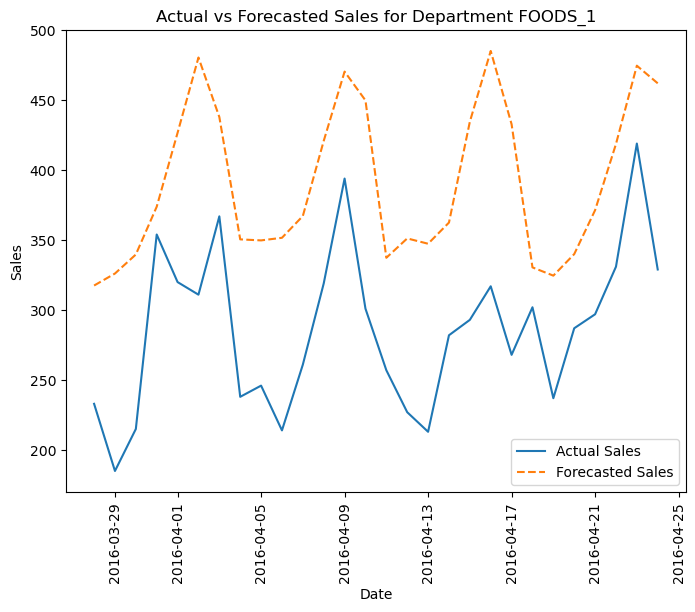

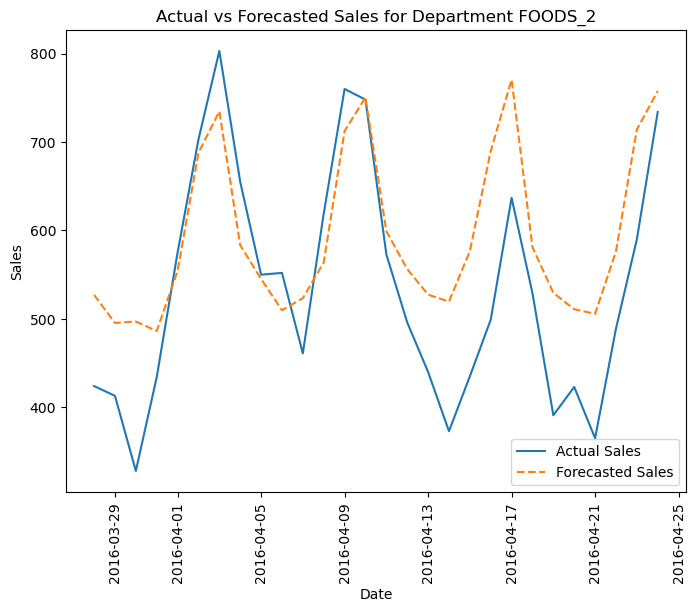

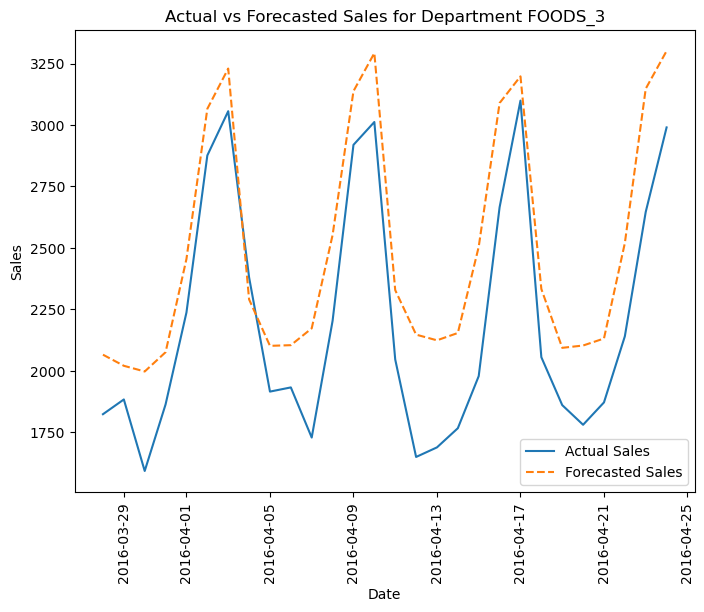

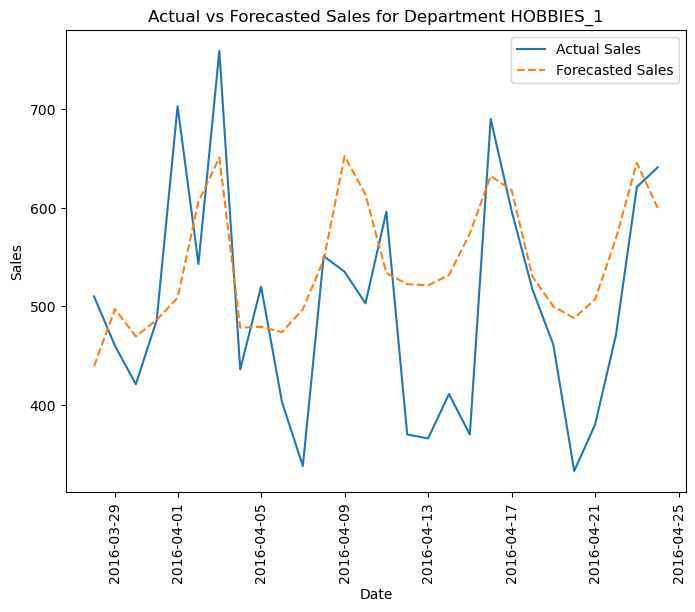

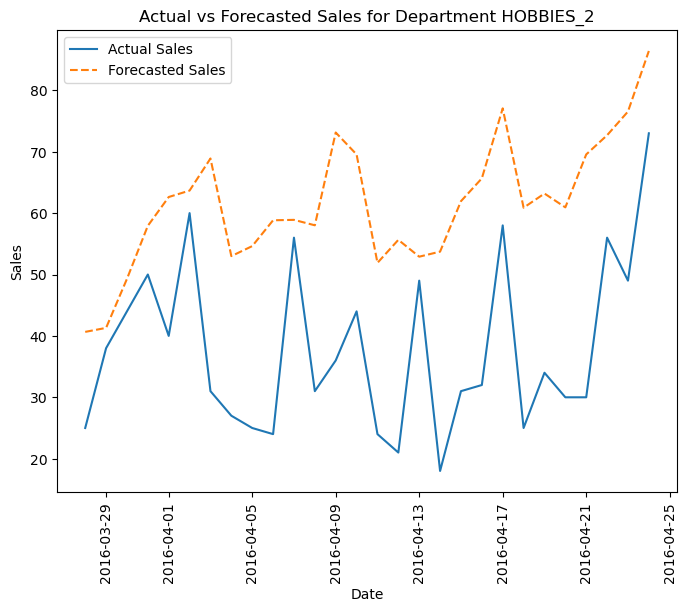

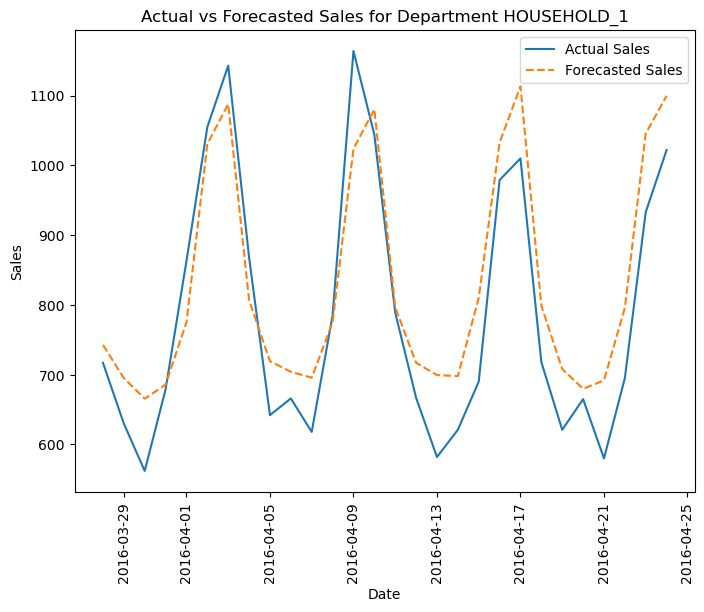

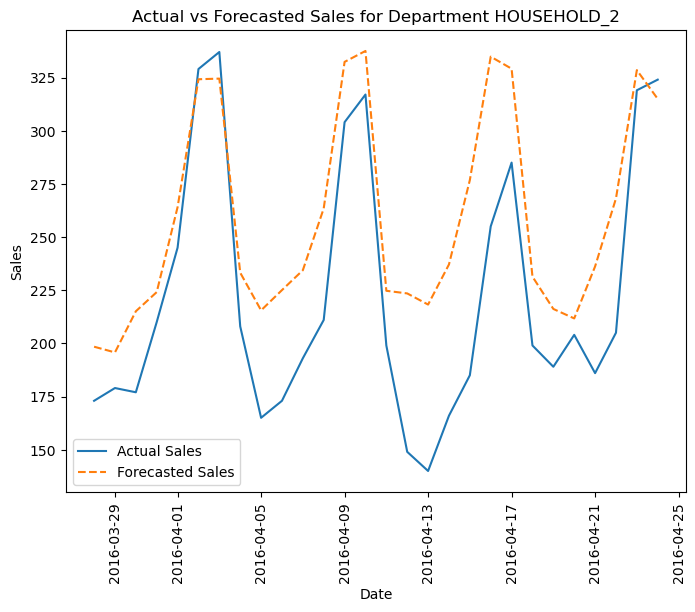

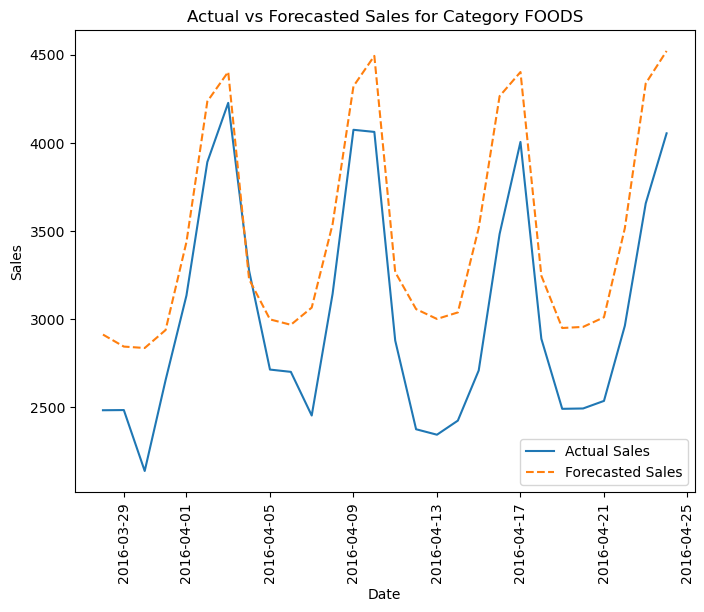

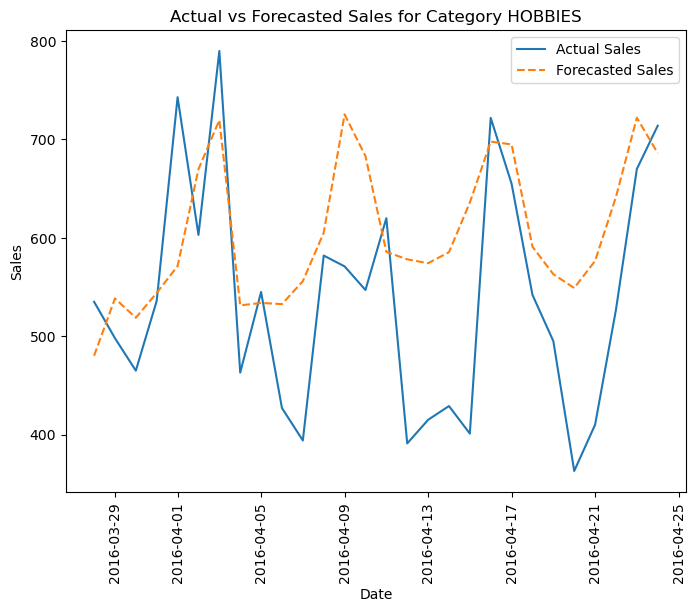

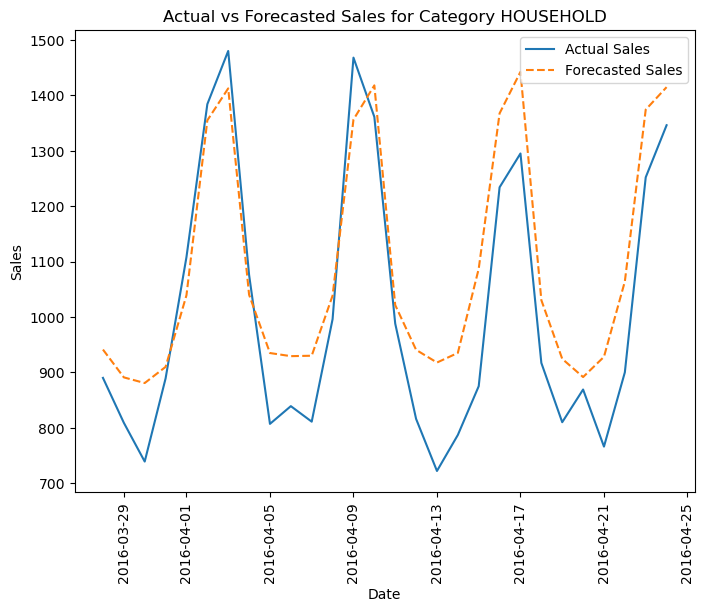

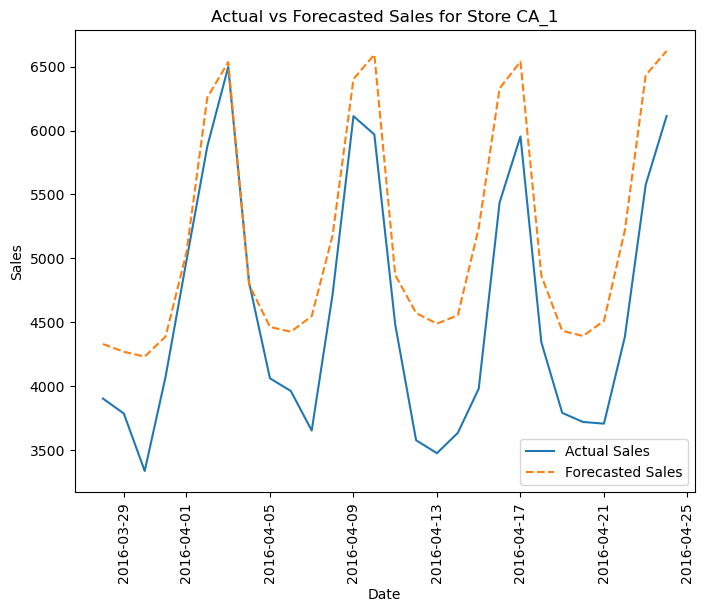

In [19]:
def plot_actual_vs_forecast(actual, forecast, level, level_name):
    actual_level = actual.groupby(['date', level])['sales'].sum().reset_index()
    forecast = forecast.rename(columns={'prediction': 'sales_forecast'})
    merged = pd.merge(actual_level, forecast, on=['date', level], suffixes=('_actual', '_forecast'))
    
    unique_levels = merged[level].unique()
    
    for lvl in unique_levels:
        plt.figure(figsize=(8, 6))
        lvl_data = merged[merged[level] == lvl]
        plt.plot(lvl_data['date'], lvl_data['sales'], label='Actual Sales')
        plt.plot(lvl_data['date'], lvl_data['sales_forecast'], label='Forecasted Sales', linestyle='--')
        plt.xticks(rotation=  90)
        plt.title(f'Actual vs Forecasted Sales for {level_name} {lvl}')
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.legend()
        plt.savefig(f'actual_vs_forecasted_sales_{level_name}_{lvl}.png', bbox_inches='tight')
        plt.show()

# Plot actual vs forecasted sales for each level
plot_actual_vs_forecast(actual_sales, department_forecasts, 'dept_id', 'Department')
plot_actual_vs_forecast(actual_sales, category_forecasts, 'cat_id', 'Category')
plot_actual_vs_forecast(actual_sales, store_forecasts, 'store_id', 'Store')